In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score

pd.set_option('display.max_colwidth', None)
plt.rcParams.update({'font.size': 12, 'figure.figsize': [12, 6]})

In [2]:
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [3]:
transactions_df = transactions_df.merge(products_df, on="ProductID", how="left")

# Aggregate customer purchases
customer_purchases = transactions_df.groupby(["CustomerID"]).agg(
    TotalTransactions = ('TransactionID', 'count'),
    TotalQuantity = ('Quantity', 'sum'),
    TotalAmount = ('TotalValue', 'sum')
    ).reset_index()

customer_purchases

,CustomerID,TotalTransactions,TotalQuantity,TotalAmount
0,C0001,5,12,3354.52
1,C0002,4,10,1862.74
2,C0003,4,14,2725.38
3,C0004,8,23,5354.88
4,C0005,3,7,2034.24
...,...,...,...,...
194,C0196,4,12,4982.88
195,C0197,3,9,1928.65
196,C0198,2,3,931.83
197,C0199,4,9,1979.28


In [4]:
# Merge customer purchases with customer details
customer_profiles = customers_df.merge(customer_purchases, on="CustomerID", how="left").fillna(0)

customer_profiles

,CustomerID,CustomerName,Region,SignupDate,TotalTransactions,TotalQuantity,TotalAmount
0,C0001,Lawrence Carroll,South America,2022-07-10,5.0,12.0,3354.52
1,C0002,Elizabeth Lutz,Asia,2022-02-13,4.0,10.0,1862.74
2,C0003,Michael Rivera,South America,2024-03-07,4.0,14.0,2725.38
3,C0004,Kathleen Rodriguez,South America,2022-10-09,8.0,23.0,5354.88
4,C0005,Laura Weber,Asia,2022-08-15,3.0,7.0,2034.24
...,...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,4.0,12.0,4982.88
196,C0197,Christina Harvey,Europe,2023-03-21,3.0,9.0,1928.65
197,C0198,Rebecca Ray,Europe,2022-02-27,2.0,3.0,931.83
198,C0199,Andrea Jenkins,Europe,2022-12-03,4.0,9.0,1979.28


In [5]:
# Perform one-hot encoding on Region
customer_profiles = pd.get_dummies(customer_profiles, columns=["Region"])

customer_features = customer_profiles.drop(columns=["CustomerID", "CustomerName", "SignupDate"])

customer_features

,TotalTransactions,TotalQuantity,TotalAmount,Region_Asia,Region_Europe,Region_North America,Region_South America
0,5.0,12.0,3354.52,False,False,False,True
1,4.0,10.0,1862.74,True,False,False,False
2,4.0,14.0,2725.38,False,False,False,True
3,8.0,23.0,5354.88,False,False,False,True
4,3.0,7.0,2034.24,True,False,False,False
...,...,...,...,...,...,...,...
195,4.0,12.0,4982.88,False,True,False,False
196,3.0,9.0,1928.65,False,True,False,False
197,2.0,3.0,931.83,False,True,False,False
198,4.0,9.0,1979.28,False,True,False,False


In [6]:
# Apply KMeans clustering
customer_features_scaled = MinMaxScaler().fit_transform(customer_features)

k_values = range(2, 11)
db_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=7)

    labels = kmeans.fit_predict(customer_features_scaled)

    db_score = davies_bouldin_score(customer_features_scaled, labels)
    silhouette = silhouette_score(customer_features_scaled, labels)

    db_scores.append(db_score)
    silhouette_scores.append(silhouette)

In [7]:
# Find the best number of clusters based on DB Index
optimal_k = k_values[np.argmin(db_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=7)
customer_profiles["Cluster"] = kmeans.fit_predict(customer_features_scaled)

In [8]:
# Calculate final DB Index and Silhouette Score
final_db_score = davies_bouldin_score(customer_features_scaled, customer_profiles["Cluster"])
final_silhouette_score = silhouette_score(customer_features_scaled, customer_profiles["Cluster"])

In [9]:
# Save clustered data
customer_profiles.to_csv("Clustered_Customers.csv", index=False)

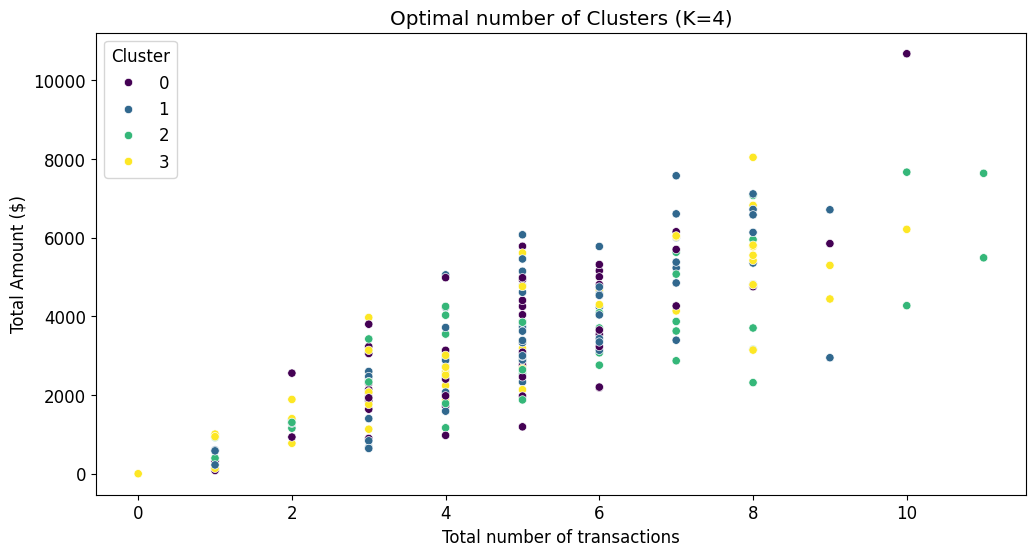

In [10]:
# Visualization of clusters
sns.scatterplot(x=customer_profiles["TotalTransactions"], y=customer_profiles["TotalAmount"], hue=customer_profiles["Cluster"], palette="viridis")
plt.xlabel("Total number of transactions")
plt.ylabel("Total Amount ($)")
plt.title(f"Optimal number of Clusters (K={optimal_k})")
plt.legend(title="Cluster")
plt.savefig("Customer_Clusters.png")
plt.show()

In [11]:
print("Optimal number of clusters:", optimal_k)
print("Davies-Bouldin Index:", final_db_score)
print("Silhouette Score:", final_silhouette_score)

Optimal number of clusters: 4
Davies-Bouldin Index: 0.4136032802536411
Silhouette Score: 0.7368738210237151
